In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl

import IPython.display as display
import PIL.Image

In [2]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model.summary()

2022-03-24 09:07:25.985162: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

# TensorFlow API version

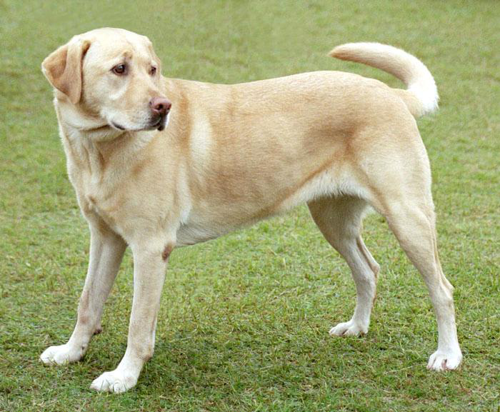

In [30]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    if type(img) != np.ndarray:
        img = np.array(img)
    display.display(PIL.Image.fromarray(img))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [31]:
from tensorflow.keras.applications import InceptionV3

class DeepDream(tf.Module):
    
    def __init__(self, base_model, layers=['mixed3', 'mixed5']):
        """Attach specified layers to the loss function"""
        layers = [base_model.get_layer(_l).output for _l in layers]
        self.model = tf.keras.Model(inputs=base_model.input, outputs=layers)
        
    def calc_loss(self, img):
        # Pass forward the image through the model to retrieve the activations.
        # Converts the image into a batch of size 1.
        img_batch = tf.expand_dims(img, axis=0)
        layer_activations = self.model(img_batch)
        if len(layer_activations) == 1:
            layer_activations = [layer_activations]

        losses = []
        for act in layer_activations:
            loss = tf.math.reduce_mean(act)
            losses.append(loss)

        return tf.reduce_sum(losses)

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = self.calc_loss(img)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [32]:
# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
   if type(img) != np.ndarray:
     img = np.array(img)
   display.display(PIL.Image.fromarray(img))

def run_deep_dream_simple(img, steps=100, step_size=0.01, sample_stride=20,
                          layers=['mixed3', 'mixed5']):
    
    # Initialize model with specific layers
    deepdream = DeepDream(base_model) #, layers=layers)

    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>sample_stride:
            run_steps = tf.constant(sample_stride)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

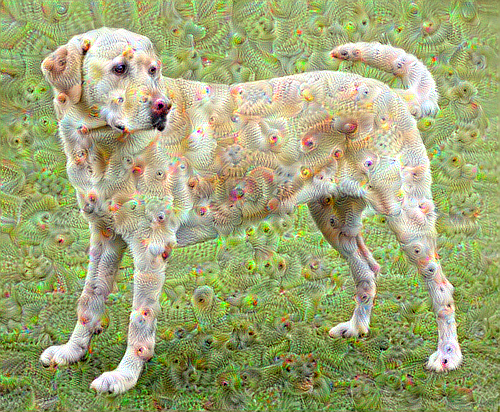

In [12]:
import PIL.Image

max_dim = 500
def load_image(path):
    img = PIL.Image.open(path)
    img.thumbnail((max_dim, max_dim))
    img = np.array(img)
    return img

dog = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
name = dog.split('/')[-1]
path = tf.keras.utils.get_file(name, origin=dog)
img = load_image(path)
dream_img = run_deep_dream_simple(img=img, 
                                  steps=100, 
                                  step_size=0.01,
                                  sample_stride=20,
                                  layers=['mixed7', 'mixed8'])

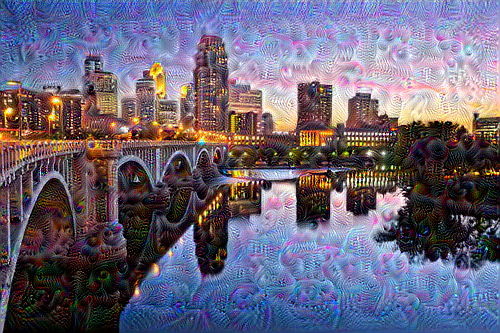

In [39]:
path = 'mpls.jpeg'
img = load_image(path)
dream_img = run_deep_dream_simple(img=img, 
                                  steps=100, 
                                  step_size=0.01,
                                  sample_stride=20,
                                  layers=['mixed1', 'mixed2'])

# Chollet's Version

In [3]:
from tensorflow.keras.applications import InceptionV3

class DeepDream(tf.Module):
    
    def __init__(self, base_model, layer_contributions):
        """Attach specified layers to the loss function"""
        self.layer_contributions = layer_contributions
        layers = [base_model.get_layer(l).output for l in layer_contributions]
        self.model = tf.keras.Model(inputs=base_model.input, outputs=layers)
        
    def calc_loss(self, img):
        # Pass forward the image through the model to retrieve the activations.
        # Converts the image into a batch of size 1.
#         img_batch = tf.expand_dims(img, axis=0)
        layer_activations = self.model(img)
        if len(layer_activations) == 1:
            layer_activations = [layer_activations]
        losses = []
        for act, coeff in zip(layer_activations, self.layer_contributions.values()):
            loss = tf.math.reduce_mean(act) * coeff
            losses.append(loss)
        return tf.reduce_sum(losses)

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[1,None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.float32))
    )
    def __call__(self, img, steps, step_size, max_loss=None):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = self.calc_loss(img)
#                 if max_loss is not None and loss > max_loss:
#                     print(f'Calculated loss ({loss})is exceeded maximum ({max_loss}).')

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [24]:
import scipy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import inception_v3

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

# def save_img(img, fname):
#     pil_img = deprocess_image(np.copy(img))
#     scipy.misc.imsave(fname, pil_img)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

# def deprocess_image(x):
#     x = x.reshape((x.shape[1], x.shape[2], 3))
#     x /= 2.
#     x += 0.5
#     x *= 255.
#     x = np.clip(x, 0, 255).astype('uint8')
#     return x

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    if type(img) != np.ndarray:
        img = np.array(img)
    display.display(PIL.Image.fromarray(img))

In [27]:
import numpy as np

def run_deep_dream_chollet(img, step=0.01, num_octave=3, 
                           octave_scale=1.4, iterations=20, 
                           max_loss=10, layer_contributions=None):
    
    # Setup default layer contributions
    if not layer_contributions:
        layer_contributions = {
            'mixed2': 0.2,
            'mixed3': 3.,
            'mixed4': 2.,
            'mixed5': 1.5}
    
    deepdream = DeepDream(base_model, layer_contributions)
    
    # Build shapes index
    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i))
                       for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]

    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0])
    for i, shape in enumerate(successive_shapes):
        print('Processing image shape', shape)
        
        # Gradient ascent
        img = resize_img(img, shape)
        loss, img = deepdream(img, steps=iterations,
                              step_size=tf.constant(step),
                              max_loss=max_loss)
        
        # Rescale
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        shrunk_original_img = resize_img(original_img, shape)
        
        display.clear_output(wait=True)
#         from IPython import embed; embed()
        show(deprocess(img[0]))
        print (f"Step {i}, loss {loss}".format(step, loss))

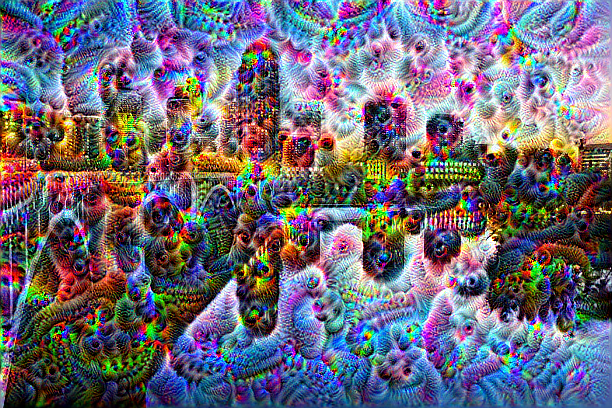

Step 4, loss 7.550413131713867


In [31]:
path = 'mpls.jpeg'
img = preprocess_image(path)

layer_contributions = {
            'mixed1': 0.2,
            'mixed2': 3.,
            'mixed3': 2.,
            'mixed4': 1.5}

run_deep_dream_chollet(img, step=0.05, num_octave=5, 
                       layer_contributions=layer_contributions)

# Style Transfer

In [37]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [38]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [39]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

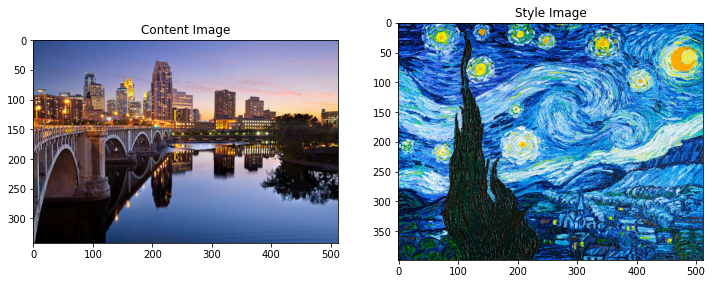

In [40]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
        
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [42]:
import tensorflow

x = tensorflow.keras.applications.vgg19.preprocess_input(content_image*255)
x = tensorflow.image.resize(x, (224, 224))
vgg = tensorflow.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
predicted_top_5 = tensorflow.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 1us/step


[('pier', 0.731561),
 ('dock', 0.12741268),
 ('steel_arch_bridge', 0.083848566),
 ('viaduct', 0.016774433),
 ('suspension_bridge', 0.0101246685)]

In [50]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

def vgg_layers(layer_names):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers, style_weight,
                 content_weight):
        super().__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.style_weight = style_weight
        self.content_weight = content_weight

        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        n = len(self.style_layers)
        style_outputs, content_outputs = (outputs[:n], outputs[n:])
        style_outputs = [gram_matrix(o) for o in style_outputs]
        
        content_dict = {k: v for k, v in zip(self.content_layers, content_outputs)}
        style_dict = {k: v for k, v in zip(self.style_layers, style_outputs)}
        
        return dict(content=content_dict, style=style_dict)
    
    def style_content_loss(self, outputs, style_targets, content_targets):
        """Unified loss function for content and loss"""
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                               for name in style_outputs.keys()])
        style_loss *= self.style_weight / len(style_outputs)

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                               for name in content_outputs.keys()])
        content_loss *= self.content_weight / len(content_outputs)
        loss = style_loss + content_loss
        return loss

In [46]:
extractor = StyleContentModel(style_layers, content_layers,
                              style_weight, content_weight)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)


opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                           for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

80150528/80134624 [==============================] - 11s 0us/step


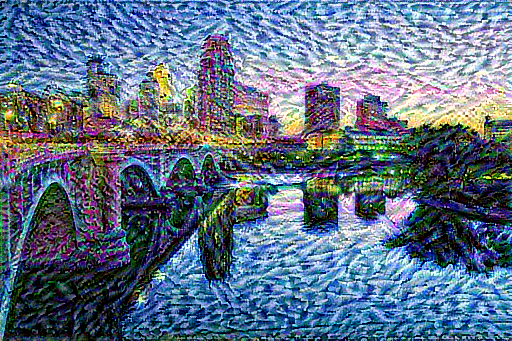

Train step: 40


In [52]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_transfer(content_image, style_image, content_layers,
                   style_layers, epochs=10, steps_per_epoch=100,
                   style_weight=1e-2, content_weight=1e4):
    
    # Initialize model and target image
    extractor = StyleContentModel(style_layers, content_layers,
                                  style_weight, content_weight)
    image = tf.Variable(content_image)

    # Get reference outputs for style and content
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    
    for i in range(epochs):
        for j in range(steps_per_epoch):
            with tf.GradientTape() as tape:
                outputs = extractor(image)
                loss = extractor.style_content_loss(outputs, 
                                                    style_targets,
                                                    content_targets)
            grad = tape.gradient(loss, image)
            opt.apply_gradients([(grad, image)])
            image.assign(clip_0_1(image))
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print('Train step:', i * steps_per_epoch)
    
content_path = 'mpls.jpeg'
style_path = 'starry.jpeg'
content_image = load_img(content_path)
style_image = load_img(style_path)
    
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

style_transfer(content_image, 
               style_image, 
               content_layers, 
               style_layers, 
               epochs=5, 
               steps_per_epoch=10)

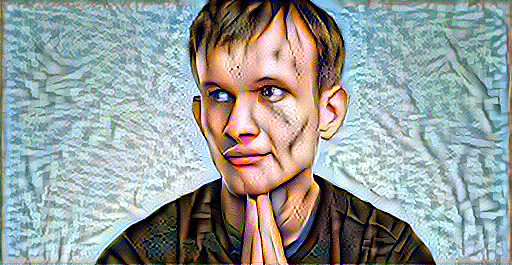

Train step: 45


In [61]:
content_path = 'vitalik.jpeg'
style_path = 'cubic.jpeg'
content_image = load_img(content_path)
style_image = load_img(style_path)
style_transfer(content_image, 
               style_image, 
               content_layers, 
               style_layers, 
               epochs=10, 
               steps_per_epoch=5)